# Predicting California’s Groundwater Levels Using Machine Learning for Sustainable Management

In [38]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Fetching the Groundwater Level Measurements via the CA Dept. of Water Resources API

In [39]:
# Fetch data from API
def fetch_groundwater_data():
    sql_query = "SELECT * FROM \"231ba173-392a-4f62-91fb-07f4a90746d1\" WHERE county_name = 'Fresno'"
    url = f"https://data.ca.gov/api/3/action/datastore_search_sql?sql={sql_query}"

    response = requests.get(url)
    
    # Check if request was successful
    if response.status_code == 200:
        data = response.json()
        records = data['result']['records']
        df = pd.DataFrame(records)
        
        # Print basic details
        print("\nData Successfully Fetched!")
        print(f"Total Records Retrieved: {len(df)}")
        print("\nPreview of Data:\n", df.head())  # Print first few rows
        
        return df
    else:
        print("Failed to fetch data. Status Code:", response.status_code)
        return None

# Call function and print results
df = fetch_groundwater_data()

# Optional: Display full column names to understand the dataset better
if df is not None:
    print("\nColumns in DataFrame:\n", df.columns.tolist())


print(f"Total Number of Rows in Dataset: {df.shape[0]}")



Data Successfully Fetched!
Total Records Retrieved: 50000

Preview of Data:
        _id                                         _full_text  \
0  1810097  '-01':4 '-022.08':24 '-04':3 '00':5,6,7 '1951'...   
1  1810098  '-01':4 '-022.08':24 '-03':3 '00':5,6,7 '1951'...   
2  1810099  '-01':4 '-02':3 '-022.08':24 '00':5,6,7 '1951'...   
3  1810100  '-01':3,4 '-022.08':24 '00':5,6,7 '1951':2 '22...   
4  1810101  '-01':4 '-022.08':24 '-12':3 '00':5,6,7 '1950'...   

            site_code            msmt_date  wlm_rpe  wlm_gse      gwe gse_gwe  \
0  366341N1197543W001  1951-04-01T00:00:00  285.700  285.700  263.700  22.000   
1  366341N1197543W001  1951-03-01T00:00:00  285.700  285.700  263.500  22.200   
2  366341N1197543W001  1951-02-01T00:00:00  285.700  285.700  263.300  22.400   
3  366341N1197543W001  1951-01-01T00:00:00  285.700  285.700  263.200  22.500   
4  366341N1197543W001  1950-12-01T00:00:00  285.700  285.700  263.000  22.700   

  wlm_qa_desc wlm_qa_detail wlm_mthd_desc wl

## Fetch and Focus on Fresno County data for better accuracy and less variability

In [40]:
# Call function and get DataFrame
df_fresno = fetch_groundwater_data()

# Save to CSV (optional)
if df_fresno is not None:
    save_csv = True  # Set to False if you don't want to save
    if save_csv:
        df_fresno.to_csv("fresno_groundwater.csv", index=False)
        print("\Fresno County data saved as 'fresno_groundwater.csv'")


Data Successfully Fetched!
Total Records Retrieved: 50000

Preview of Data:
        _id                                         _full_text  \
0  1810007  '-022.08':24 '-08':3 '-10':4 '00':5,6,7 '1976'...   
1  1810097  '-01':4 '-022.08':24 '-04':3 '00':5,6,7 '1951'...   
2  1810098  '-01':4 '-022.08':24 '-03':3 '00':5,6,7 '1951'...   
3  1810099  '-01':4 '-02':3 '-022.08':24 '00':5,6,7 '1951'...   
4  1810100  '-01':3,4 '-022.08':24 '00':5,6,7 '1951':2 '22...   

            site_code            msmt_date  wlm_rpe  wlm_gse      gwe gse_gwe  \
0  366341N1197543W001  1976-08-10T00:00:00  285.700  285.700  250.200  35.500   
1  366341N1197543W001  1951-04-01T00:00:00  285.700  285.700  263.700  22.000   
2  366341N1197543W001  1951-03-01T00:00:00  285.700  285.700  263.500  22.200   
3  366341N1197543W001  1951-02-01T00:00:00  285.700  285.700  263.300  22.400   
4  366341N1197543W001  1951-01-01T00:00:00  285.700  285.700  263.200  22.500   

  wlm_qa_desc wlm_qa_detail wlm_mthd_desc wl

## Missing Values Analysis

/var/folders/z2/ns_w84j13gdbd48gnvk2np5c0000gn/T/ipykernel_42939/4281829942.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Column", y="Missing Percentage", data=missing_df, palette="Reds")


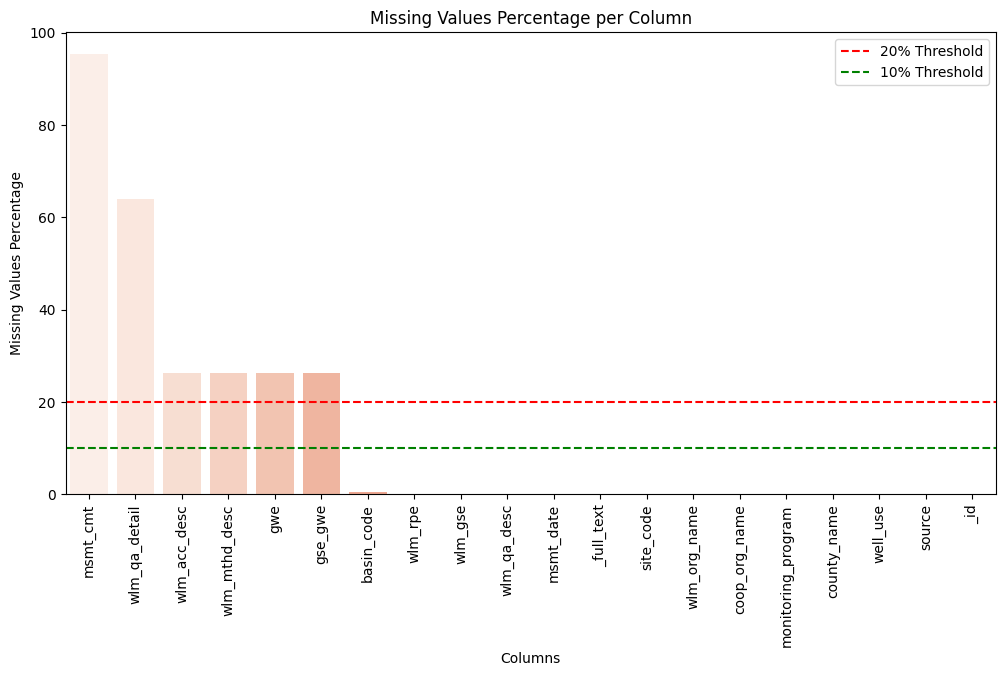

In [41]:
# Load the dataset
file_path = "./fresno_groundwater.csv"

# Read the dataset
df = pd.read_csv(file_path)

# Calculate missing values percentage per column
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Create a DataFrame for visualization
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing Percentage': missing_percentage
}).sort_values(by="Missing Percentage", ascending=False)

# Plot the missing values
plt.figure(figsize=(12, 6))
sns.barplot(x="Column", y="Missing Percentage", data=missing_df, palette="Reds")
plt.xticks(rotation=90)
plt.axhline(y=20, color='red', linestyle='--', label='20% Threshold')
plt.axhline(y=10, color='green', linestyle='--', label='10% Threshold')
plt.ylabel("Missing Values Percentage")
plt.xlabel("Columns")
plt.title("Missing Values Percentage per Column")
plt.legend()
plt.show()



## Cleaning the data

/var/folders/z2/ns_w84j13gdbd48gnvk2np5c0000gn/T/ipykernel_42939/427414231.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Column", y="Missing Percentage", data=missing_df, palette="Reds")


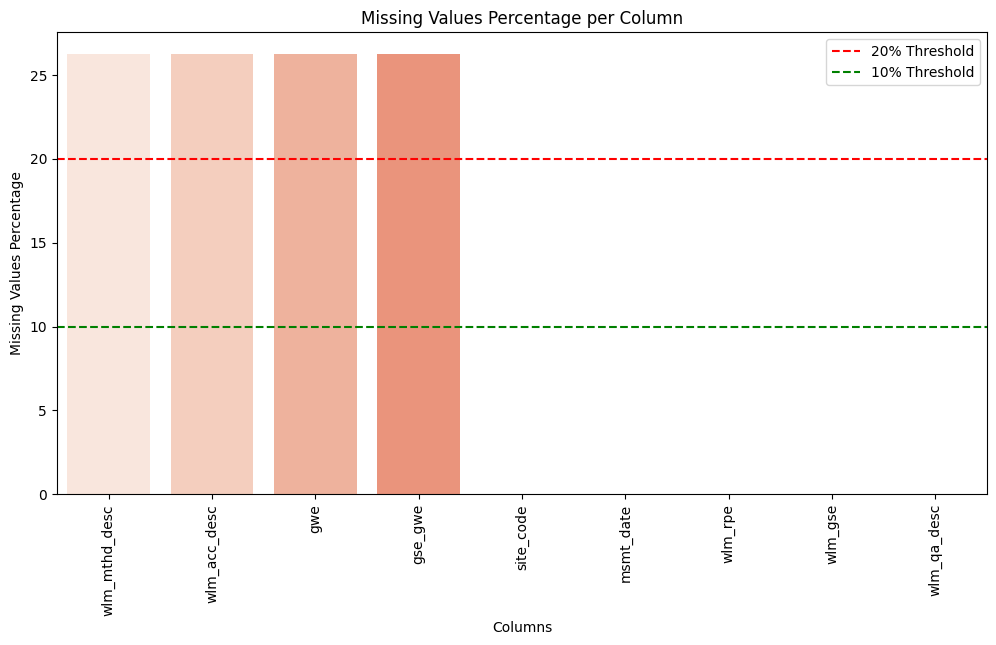

Cleaned dataset saved as 'cleaned_dataset.csv'
                      Column  Missing Percentage
wlm_mthd_desc  wlm_mthd_desc              26.240
wlm_acc_desc    wlm_acc_desc              26.240
gwe                      gwe              26.236
gse_gwe              gse_gwe              26.236
site_code          site_code               0.000
msmt_date          msmt_date               0.000
wlm_rpe              wlm_rpe               0.000
wlm_gse              wlm_gse               0.000
wlm_qa_desc      wlm_qa_desc               0.000


In [48]:
# Drop unnecessary columns
columns_to_remove = ["msmt_cmt", "wlm_qa_detail", "wlm_org_name", "coop_org_name", "monitoring_program", "county_name", "source", "well_use", "_id", "basin_code", "_full_text"]
df_cleaned = df.drop(columns=[col for col in columns_to_remove if col in df.columns], errors='ignore')

# Remove columns that contain only zeros and are text-based columns like descriptions, IDs, etc.
df_cleaned = df_cleaned.loc[:, (df_cleaned != 0).any(axis=0)]

# Calculate missing values percentage per column
missing_values = df_cleaned.isnull().sum()
missing_percentage = (missing_values / len(df_cleaned)) * 100

# Create a DataFrame for visualization
missing_df = pd.DataFrame({
    'Column': df_cleaned.columns,
    'Missing Percentage': missing_percentage
}).sort_values(by="Missing Percentage", ascending=False)

# Plot the missing values
plt.figure(figsize=(12, 6))
sns.barplot(x="Column", y="Missing Percentage", data=missing_df, palette="Reds")
plt.xticks(rotation=90)
plt.axhline(y=20, color='red', linestyle='--', label='20% Threshold')
plt.axhline(y=10, color='green', linestyle='--', label='10% Threshold')
plt.ylabel("Missing Values Percentage")
plt.xlabel("Columns")
plt.title("Missing Values Percentage per Column")
plt.legend()
plt.show()

# Save the cleaned dataset (optional)
df_cleaned.to_csv("cleaned_dataset.csv", index=False)
print("Cleaned dataset saved as 'cleaned_dataset.csv'")

# Display missing values analysis
print(missing_df)

## Function to plot the data per type of variables

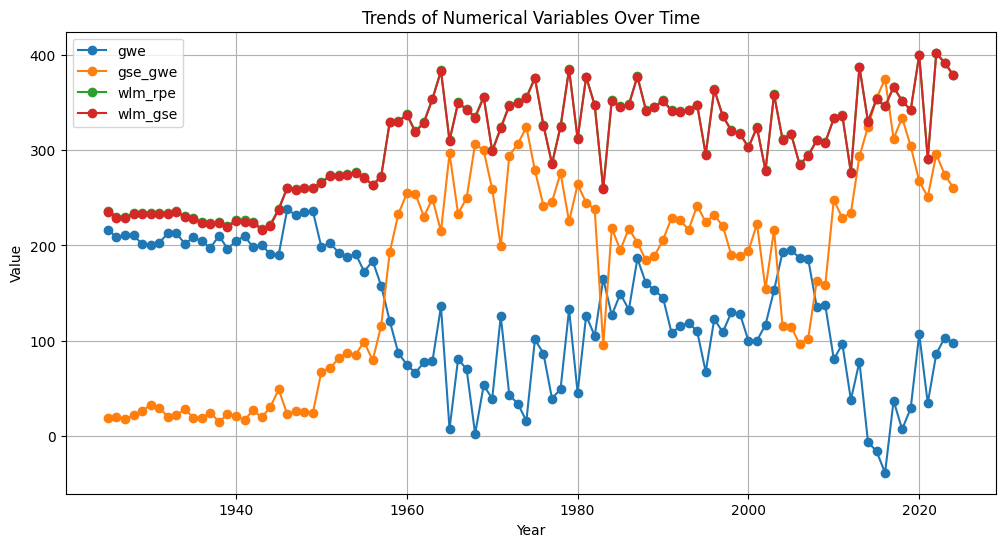

In [51]:
def plot_numerical_trends(df, variables, date_column="msmt_date"):
    # Ensure date column is in datetime format
    if date_column in df.columns:
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
        df["year"] = df[date_column].dt.year  # Extract year
    else:
        print(f"Date column '{date_column}' not found.")
        return
    
    # Keep only numerical columns from the provided variable list
    numeric_vars = [var for var in variables if var in df.columns and pd.api.types.is_numeric_dtype(df[var])]
    
    if not numeric_vars:
        print("No numerical variables found for plotting.")
        return

    # Create a line plot for each numerical variable over the years
    plt.figure(figsize=(12, 6))
    for var in numeric_vars:
        yearly_avg = df.groupby("year")[var].mean()  # Aggregate by year
        plt.plot(yearly_avg.index, yearly_avg.values, marker="o", label=var)

    plt.xlabel("Year (1925-2024)")
    plt.ylabel("Value (ft)")
    plt.title("Trends of Numerical Variables Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the variables to analyze
variables = [
    "wlm_mthd_desc", "wlm_acc_desc", "gwe", "gse_gwe", "site_code", "msmt_date", "wlm_rpe", "wlm_gse", "wlm_qa_desc"
]

# Load your dataset
file_path = "cleaned_dataset.csv" 
df = pd.read_csv(file_path)

# Call the function
plot_numerical_trends(df, variables)



## NEXT STEP: To resample dataframe to work  with monthly value

# Data Preprocessing
def preprocess_data(df):
    required_columns = ['measurement_date', 'site_code', 'gs_elev', 'rp_elev', 'wl_below_surface']
    available_columns = df.columns.tolist()
    missing_columns = [col for col in required_columns if col not in available_columns]
    
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        return pd.DataFrame()
    
    df = df[required_columns]
    df.dropna(inplace=True)
    df['measurement_date'] = pd.to_datetime(df['measurement_date'], errors='coerce')
    df.dropna(subset=['measurement_date'], inplace=True)
    df.sort_values(by=['measurement_date'], inplace=True)
    
    label_encoder = LabelEncoder()
    df['site_code'] = label_encoder.fit_transform(df['site_code'])
    return df


# Feature Engineering
def feature_engineering(df):
    df['year'] = df['measurement_date'].dt.year
    df['month'] = df['measurement_date'].dt.month
    df['day'] = df['measurement_date'].dt.day
    df.drop(columns=['measurement_date'], inplace=True)
    return df

raw_df = fetch_groundwater_data()
if not raw_df.empty:
    processed_df = preprocess_data(raw_df)
    if not processed_df.empty:
        processed_df = feature_engineering(processed_df)
        processed_df.to_csv("groundwater_data.csv", index=False)
    else:
        print("Data preprocessing failed. No further steps executed.")
else:
    print("Data fetching failed. No further steps executed.")

# Splitting Data
X = processed_df.drop(columns=['wl_below_surface'])
y = processed_df['wl_below_surface']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
